# Aillio Bullet Roast Data Analysis

In [3]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import statsmodels.api as sm

import dump_roasts

In [4]:
roast_samples_fields = [
    'beanDerivative',
    'beanTemperature',
    'drumTemperature',
]

controls = {
    0: 'power',
    1: 'fan',
    2: 'drum',
}

def set_roast_samples_controls(roast_samples, actions):
    for control_type in controls.values():
        roast_samples[control_type] = None

    control_values = {}
    for action in actions:
        control_name = controls.get(action['ctrlType'], None)
        if control_name is None:
            continue
        
        if control_name not in control_values:
            control_values[control_name] = (0, action['value'])
        else:
            prior_index, prior_value = control_values[control_name]
            control_loc = roast_samples.columns.get_loc(control_name)
            roast_samples.iloc[prior_index:action['index'], control_loc] = prior_value
            control_values[control_name] = (action['index'], action['value'])

    for control_name, (index, value) in control_values.items():
        control_loc = roast_samples.columns.get_loc(control_name)
        roast_samples.iloc[index:, control_loc] = value


def create_roast_samples(roast_json, roast):
    roast_samples_columns = {f:roast_json[f] for f in roast_samples_fields}
    roast_samples = pd.DataFrame.from_dict(roast_samples_columns)
    sample_period = 1 / roast['sampleRate']
    roast_samples['time'] = pd.Series([i * sample_period for i in range(0, len(roast_samples))])
    roast_samples['uid'] = roast['uid']
    roast_samples['smoothDrumTemperature'] = roast_samples['drumTemperature'].ewm(com=0.99).mean()
    #roast_samples['smoothDrumDerivative'] = (roast_samples['drumTemperature'].diff() * 60 / sample_period).ewm(span=50).mean()
    y = (roast_samples['drumTemperature'].diff() * 60 / sample_period).values
    x = roast_samples['time'].values
    roast_samples['smoothDrumDerivative'] = pd.Series(sm.nonparametric.lowess(y, x, frac=0.1)[:,1])
    set_roast_samples_controls(roast_samples, roast_json['actions']['actionTimeList'])

    return roast_samples

    
def load_roasts(roast_dirname):
    roasts = []
    roasts_samples = []

    for roast_filename in os.listdir(roast_dirname):
        roast_pathname = os.path.join(roast_dirname, roast_filename)
        print(f'loading {roast_pathname}')
        with open(roast_pathname, 'r', encoding='utf-8') as roast_file:
            roast_json = json.load(roast_file)

            roast = dump_roasts.create_roast(roast_json)
            roasts.append(roast)

            roast_samples = create_roast_samples(roast_json, roast)
            roasts_samples.append(roast_samples)
    
    all_roasts = pd.DataFrame(roasts).sort_values('dateTime').reset_index(drop=True)
    all_roasts['backToBack'] = all_roasts['roastNumber'] == all_roasts['roastNumber'].shift(1)

    all_roasts_samples = pd.concat(roasts_samples, ignore_index=True)
    return all_roasts, all_roasts_samples

roasts, roasts_samples = load_roasts('./roasts')
roast_filters = [
    roasts['ambient'].notna(),
    roasts['humidity'].notna(),
    roasts['firmware'] >= 540,
    roasts['weightGreen'] > 0,
    roasts['weightRoasted'] > 0,
    roasts['indexYellowingStart'] > 0,
    roasts['indexFirstCrackStart'] > 0,
    roasts['drumChargeTemperature'] > 200,
]

roasts_filter = True
for roast_filter in roast_filters:
    roasts_filter &= roast_filter
roasts = roasts[roasts_filter].reset_index(drop=True)

#with pd.option_context("display.min_rows", None, "display.max_rows", 40, "display.max_columns", 40):
#    display(roasts)
    
feature_columns = ['ambient', 'humidity', 'weightGreen', 'drumChargeTemperature', 'beanChargeTemperature']
roasts_samples = pd.merge(roasts, roasts_samples, how='left', on='uid')
with pd.option_context('display.max_rows', 100, 'display.max_columns', 40):
    display(roasts_samples)


loading ./roasts/e87355ed-04cf-4cd0-8553-7f22b7fd8223
loading ./roasts/003f066d-de67-46c2-9cfd-d6003519f99e
loading ./roasts/_zMOdgWP6G90K5OoxO6t3
loading ./roasts/de53658a-7a91-410e-973f-7555e693876e
loading ./roasts/ad6b9db9-7c5d-4944-894f-2403fe847b3c
loading ./roasts/a62fb4f5-7fb7-4aa8-9a4b-c0a0421b4adb
loading ./roasts/c433N9s68dhNYHRyV9tgu
loading ./roasts/_doMKzmtWuG3AihFicn4n
loading ./roasts/3f030e97-934e-4233-b93b-57321a62364f
loading ./roasts/6dd15d01-4a97-4e65-b13d-2c914d1d45dd
loading ./roasts/FyjqinbiT8L3TD23yEulI
loading ./roasts/069148bf-6479-460f-871f-f2feee670611
loading ./roasts/TJKIn4D6DW0MDAMiUbYlI
loading ./roasts/b99f9de9-b760-41be-9435-5f779349b469
loading ./roasts/bf102803-2db3-418b-95df-3d224730ac00
loading ./roasts/3ZKcLsz6nxQidskzU6WxN
loading ./roasts/c988abf5-4859-4fb2-9a91-0149ffd57755
loading ./roasts/1fcdd896-5937-477f-b368-0fccaa1be745
loading ./roasts/ff9e0f30-8cb0-4de7-a1fa-967f5510c54b
loading ./roasts/94d00711-01fa-49af-aab5-9056b3699761
loading ./

,dateTime,uid,roastNumber,roastName,beanId,rating,serialNumber,firmware,hardware,ambient,humidity,weightGreen,weightRoasted,preheatTemperature,beanChargeTemperature,beanDropTemperature,drumChargeTemperature,drumDropTemperature,totalRoastTime,sampleRate,roastStartIndex,indexYellowingStart,indexFirstCrackStart,indexFirstCrackEnd,indexSecondCrackStart,indexSecondCrackEnd,roastEndIndex,backToBack,beanDerivative,beanTemperature,drumTemperature,time,smoothDrumTemperature,smoothDrumDerivative,power,fan,drum
0,1581738164269,3d09fa65-4f3a-4a5a-a55a-9fc6d5cbda3f,34,Ryan Ethiopia Yukiro Coop v1,ebc65cf0-04e9-4348-84fe-154e217f0f61,None,1578,540,50462976,14.0,68.0,455.0,397.0,250,165.3,200.3,250.4,211.0,576,2,0,342,832,0,0,0,1157,True,11.0,165.3,250.4,0.0,250.400000,-8.010109,6,2,9
1,1581738164269,3d09fa65-4f3a-4a5a-a55a-9fc6d5cbda3f,34,Ryan Ethiopia Yukiro Coop v1,ebc65cf0-04e9-4348-84fe-154e217f0f61,None,1578,540,50462976,14.0,68.0,455.0,397.0,250,165.3,200.3,250.4,211.0,576,2,0,342,832,0,0,0,1157,True,12.1,165.4,250.8,0.5,250.667114,-7.806286,6,2,9
2,1581738164269,3d09fa65-4f3a-4a5a-a55a-9fc6d5cbda3f,34,Ryan Ethiopia Yukiro Coop v1,ebc65cf0-04e9-4348-84fe-154e217f0f61,None,1578,540,50462976,14.0,68.0,455.0,397.0,250,165.3,200.3,250.4,211.0,576,2,0,342,832,0,0,0,1157,True,12.4,165.5,250.5,1.0,250.571346,-7.602279,6,2,9
3,1581738164269,3d09fa65-4f3a-4a5a-a55a-9fc6d5cbda3f,34,Ryan Ethiopia Yukiro Coop v1,ebc65cf0-04e9-4348-84fe-154e217f0f61,None,1578,540,50462976,14.0,68.0,455.0,397.0,250,165.3,200.3,250.4,211.0,576,2,0,342,832,0,0,0,1157,True,12.3,165.6,250.3,1.5,250.426094,-7.397956,6,2,9
4,1581738164269,3d09fa65-4f3a-4a5a-a55a-9fc6d5cbda3f,34,Ryan Ethiopia Yukiro Coop v1,ebc65cf0-04e9-4348-84fe-154e217f0f61,None,1578,540,50462976,14.0,68.0,455.0,397.0,250,165.3,200.3,250.4,211.0,576,2,0,342,832,0,0,0,1157,True,11.8,165.7,248.8,2.0,249.583278,-7.193141,6,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60344,1615139632557,c2BjyIvAZ0JYAJT8T_ROo,90,Yemen Mokha Matari,e62091d7-e83c-411c-abf9-56ae01a7ad66,0,1578,558,50462976,16.0,70.0,455.0,380.0,250,154.5,200.4,247.2,213.3,743,2,0,480,1124,0,0,0,1487,False,3.0,200.3,213.2,741.0,213.198483,2.148183,5,5,9
60345,1615139632557,c2BjyIvAZ0JYAJT8T_ROo,90,Yemen Mokha Matari,e62091d7-e83c-411c-abf9-56ae01a7ad66,0,1578,558,50462976,16.0,70.0,455.0,380.0,250,154.5,200.4,247.2,213.3,743,2,0,480,1124,0,0,0,1487,False,2.5,200.3,213.3,741.5,213.249496,2.139125,5,5,9
60346,1615139632557,c2BjyIvAZ0JYAJT8T_ROo,90,Yemen Mokha Matari,e62091d7-e83c-411c-abf9-56ae01a7ad66,0,1578,558,50462976,16.0,70.0,455.0,380.0,250,154.5,200.4,247.2,213.3,743,2,0,480,1124,0,0,0,1487,False,2.2,200.3,213.3,742.0,213.274875,2.129866,5,5,9
60347,1615139632557,c2BjyIvAZ0JYAJT8T_ROo,90,Yemen Mokha Matari,e62091d7-e83c-411c-abf9-56ae01a7ad66,0,1578,558,50462976,16.0,70.0,455.0,380.0,250,154.5,200.4,247.2,213.3,743,2,0,480,1124,0,0,0,1487,False,2.1,200.3,213.3,742.5,213.287501,2.120409,5,5,9


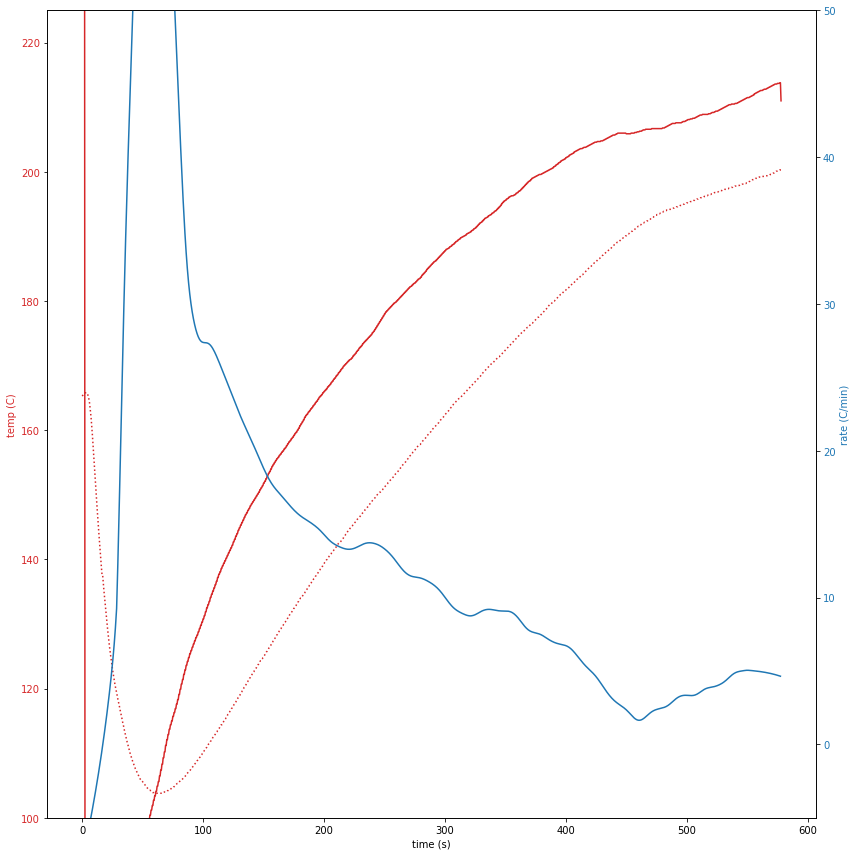

OK


In [5]:
roast_samples = roasts_samples[roasts_samples['uid'] == '3d09fa65-4f3a-4a5a-a55a-9fc6d5cbda3f']
fig, ax_temp = plt.subplots(figsize=(12, 12))
color_temp = 'tab:red'
ax_temp.set_xlabel('time (s)')
ax_temp.set_ylabel('temp (C)', color=color_temp)
ax_temp.set_ylim((100, 225))
ax_temp.plot(roast_samples['time'], roast_samples['drumTemperature'], color=color_temp)
ax_temp.plot(roast_samples['time'], roast_samples['beanTemperature'], color=color_temp, linestyle=':')
ax_temp.tick_params(axis='y', labelcolor=color_temp)

ax_rate = ax_temp.twinx()
color_rate = 'tab:blue'
ax_rate.set_ylabel('rate (C/min)', color=color_rate)
ax_rate.set_ylim((-5, 50))
ax_rate.plot(roast_samples['time'], roast_samples['smoothDrumDerivative'], color=color_rate)
ax_rate.tick_params(axis='y', labelcolor=color_rate)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
print('OK')